In [942]:
import glob
import numpy as np
import datetime
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import cv2



In [943]:
def set_axis(x: np.ndarray, no_labels: int = 7)->tuple[np.ndarray, np.ndarray]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels

In [944]:
path_out = 'train_data/'
files = glob.glob(path_out+"*")
files.sort()

In [945]:
dx = 5.106500953873407
dt = 0.0016

data = []
first_id = 30
first_filename = files[first_id]
for file in files[first_id:first_id+10]:
    data.append(np.load(file))
data = np.concatenate(data).astype(np.float32)
time_start = datetime.datetime.strptime(
    '2024-05-07 ' + first_filename.split("/")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')

columns = np.arange(len(data[0])) * dx

df = pd.DataFrame(data=data, index=index, columns=columns)

In [946]:
def automedian(img: np.ndarray, struct: np.ndarray) -> np.ndarray:
    img_O = cv2.morphologyEx(img, cv2.MORPH_OPEN, struct)
    img_CO = cv2.morphologyEx(img_O, cv2.MORPH_CLOSE, struct)
    img_OCO = cv2.morphologyEx(img_CO, cv2.MORPH_OPEN, struct)

    img_C = cv2.morphologyEx(img, cv2.MORPH_CLOSE, struct)
    img_OC = cv2.morphologyEx(img_C, cv2.MORPH_OPEN, struct)
    img_COC = cv2.morphologyEx(img_OC, cv2.MORPH_CLOSE, struct)
    img_Q = np.minimum(img, img_COC)

    img_A = np.maximum(img_Q, img_OCO)

    return img_A

In [947]:

data -= np.mean(data)
data = np.abs(data) 
low, high = np.percentile(data, [3, 99]) 
norm = Normalize(vmin=low, vmax=high, clip=True)
data = np.clip(data, low, high).astype(np.float32)
data = cv2.bilateralFilter(data, 9, 100, 100) #https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html

struct = np.ones([5, 5], np.uint8)

data = automedian(data, struct)

df_processed = pd.DataFrame(data, index=df.index, columns=df.columns)

#https://stackoverflow.com/questions/71425968/remove-horizontal-lines-with-open-cv possibly interesting
# https://docs.opencv.org/3.2.0/d1/dee/tutorial_moprh_lines_detection.html

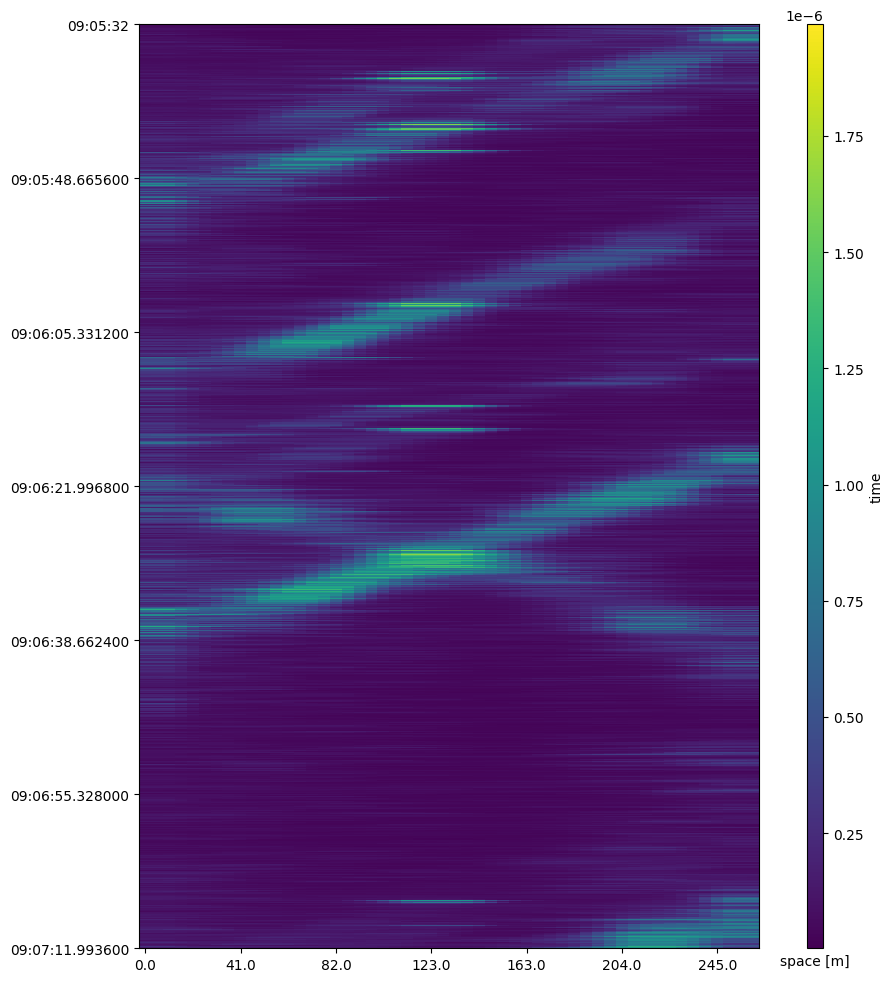

In [948]:
fig = plt.figure(figsize=(8,12))
ax = plt.axes()
cax = fig.add_axes((ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height))
x_positions, x_labels = set_axis(df_processed.columns)
ax.set_xticks(x_positions, np.round(x_labels))
y_positions, y_labels = set_axis(df_processed.index.time)
ax.set_yticks(y_positions, y_labels)
im = ax.imshow(df_processed,interpolation='none',aspect='auto', norm=norm)
plt.colorbar(im, cax=cax)
plt.ylabel('time')
plt.xlabel('space [m]')


plt.show()

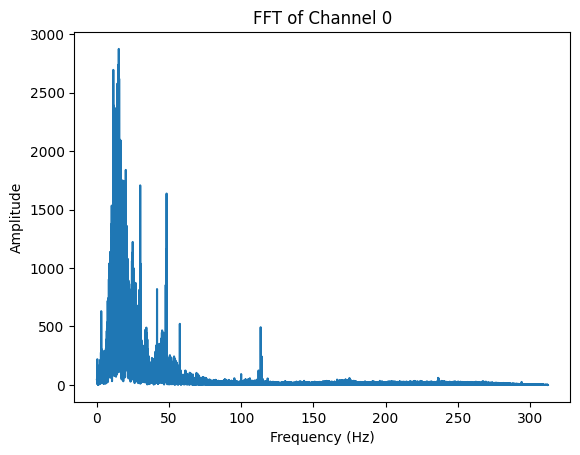

In [949]:
from scipy.fft import rfft, rfftfreq
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt

data = df.copy().to_numpy()  # (time, space)
# fs = 1 / dt                   # sampling frequency

# 1️⃣ Remove static background (mean subtraction per spatial channel)
# data = data - np.mean(data, axis=0, keepdims=True)


# 3️⃣ Standardization
data_std = (data - np.mean(data)) / np.std(data)

df_processed = pd.DataFrame(data_std, index=df.index, columns=df.columns)

freqs = rfftfreq(len(df), dt)
fft_result = np.abs(rfft(df_processed.to_numpy(), axis=0))

# Example plot for channel 0
import matplotlib.pyplot as plt
plt.plot(freqs, fft_result[:,0])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Channel 0")
plt.show()


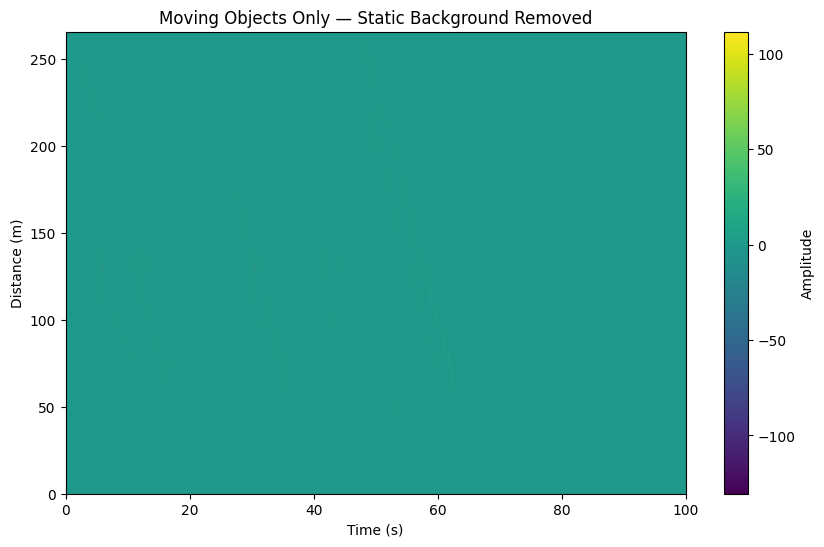

In [950]:
plt.figure(figsize=(10,6))
plt.imshow(df_processed.T, aspect="auto", origin="lower",
           extent=[0, len(df)*dt, 0, len(df.columns)*dx])
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.title("Moving Objects Only — Static Background Removed")
plt.colorbar(label="Amplitude")
plt.show()
